In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import plotly.express as px
from xgboost import XGBClassifier
from sklearn.metrics import RocCurveDisplay


In [2]:
def show_confusion_matrix(model, y_test,y_pred, normalize_matrix):
    """
    Displays the confusion matrix and classification report for a given model's predictions.

    Parameters:
        - model: The trained model or estimator.
        - y_test: The true labels of the test set.
        - y_pred: The predicted labels of the test set.
        - normalize_matrix: A string indicating whether to normalize the confusion matrix.
                            Possible values: 'yes' or 'no'.

    Returns:
        None

    Example usage:
        show_confusion_matrix(clf_rf, y_test, y_pred, normalize_matrix='no')

    Import necessary libraries :
        from sklearn.metrics import confusion_matrix
        from sklearn.metrics import classification_report
        import plotly.express as px
        import numpy as np
    """
    cm = []
    if normalize_matrix == 'yes':
        cm = confusion_matrix(y_test,y_pred, normalize_matrix='all')
        cm = np.around(cm, decimals=2)
    if normalize_matrix == 'no':
        cm = confusion_matrix(y_test,y_pred)
    fig = px.imshow(cm,
                    text_auto=True,
                    color_continuous_scale='Blues',
                    x = list(map(str, model.classes_)),
                    y = list(map(str, model.classes_)))
    fig.update_layout(title='Confusion Matrix <br><sup>'+str(model.estimator)+'',
                        width=450,
                        height=400)
    fig.update_xaxes(title='Predicted Labels')
    fig.update_yaxes(title='True Labels')
    fig.show()

    print("Classification report : ")
    print(classification_report(y_test, y_pred))

In [3]:
def show_histogram(df, x, bins = None, decimals = '.1f', log_y = False, uni_color = '#00b3ff', width = 500):
    """
    Displays a histogram using the Plotly library.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - x (str): The column name from the DataFrame to plot the histogram.
    - bins (int or None, optional): The number of bins to use in the histogram. If None, an automatic bin calculation is used. Default is None.
    - decimals (str, optional): The format string for displaying the bin counts as text. Default is '.1f'.
    - log_y (bool, optional): Whether to use a logarithmic scale on the y-axis. Default is False.
    - uni_color (str, optional): The color code for the histogram bars. Default is '#00b3ff'.
    - width (int, optional): The width of the histogram plot in pixels. Default is 500.

    Returns:
    - None: This function does not return any value but prints the graph.

    Dependencies:
    - pandas
    - plotly.express (imported as px)
    """
    fig = px.histogram(df, 
                        x=x,
                        text_auto = decimals,
                        nbins = bins,
                        log_y = log_y,
                        color_discrete_sequence = [uni_color],
                        width=width,
                        height=400)
    fig.update_xaxes(title=x)
    fig.update_yaxes(title='Count')
    fig.update_traces(textposition='outside')
    fig.update_layout(plot_bgcolor='rgba(0, 0, 0, 0)',paper_bgcolor='rgba(0, 0, 0, 0)', margin=dict(l=50, r=50, t=50, b=50))
    fig.show()

# Data Exploration

In [34]:
# import data
df = pd.read_csv("./data.csv")

In [35]:
# check on how it looks like
df.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,62,M,ATA,120,254,0,LVH,93,Y,0.0,Flat,1
1,49,M,TA,130,0,0,ST,145,N,3.0,Flat,1
2,56,M,NAP,130,167,0,Normal,114,N,0.0,Up,0
3,59,M,ASY,130,126,0,Normal,125,N,0.0,Flat,1
4,55,F,ATA,110,344,0,ST,160,N,0.0,Up,0
5,55,M,ASY,132,353,0,Normal,132,Y,1.2,Flat,1
6,48,M,ASY,140,208,0,Normal,159,Y,1.5,Up,1
7,66,F,ASY,155,0,1,Normal,90,N,0.0,Flat,1
8,47,M,ASY,110,0,1,ST,149,N,2.1,Up,1
9,54,M,ASY,150,365,0,ST,134,N,1.0,Up,0


In [36]:
# examine dataset size
print(df.shape)

(868, 12)


In [7]:
# check if there are any missing values
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [8]:
# check if there is any duplicated rows
df[df.duplicated()].shape[0]

0

In [9]:
# examine main statistics calculated on numerical features
df.describe(exclude=object)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [10]:
# check the number of distinct values for each features
print(df.nunique())

Age                50
Sex                 2
ChestPainType       4
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
HeartDisease        2
dtype: int64


In [11]:
# transform a numerical feature with only two distinct values into a categorical feature
df['FastingBS'] = df['FastingBS'].replace({0: 'No', 1: 'Yes'})

In [12]:
# check main statistics on categorical features
df.describe(include=object)

,Sex,ChestPainType,FastingBS,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918,918
unique,2,4,2,3,2,3
top,M,ASY,No,Normal,N,Flat
freq,725,496,704,552,547,460


In [13]:
# verify feature types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    object 
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 86.2+ KB


In [14]:
# seperate numerical and categorical features into two datasets
df_cat = df.select_dtypes(exclude=["int64","float64"]).reset_index(drop=True)
df_num = df.select_dtypes(exclude=["object"]).reset_index(drop=True)

In [15]:
# show distibutions of each categorical feature
for c in df_cat.columns:
    show_histogram(df, x=c)

In [16]:
# show distibutions of each numerical feature
for c in df_num.columns:
    show_histogram(df, x=c, decimals = '.0f', width=1000)

In [17]:
# check on the distribution of heart disease for individuals with 0 cholesterol
df[df['Cholesterol'] == 0]['HeartDisease'].value_counts()

1    152
0     20
Name: HeartDisease, dtype: int64

# Data Preperation

In [18]:
# seperate target variable from dataset
X = df.drop(['HeartDisease'], axis=1)
y =  df['HeartDisease']

In [19]:
# create train and test datasets after shuffling the rows
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7, shuffle = True)

In [20]:
# we seperate categorical and numerical features on the train and test datasets
X_train_cat = X_train.select_dtypes(exclude=["int64","float64"]).reset_index(drop=True)
X_train_num = X_train.select_dtypes(exclude=["object"]).reset_index(drop=True)

X_test_cat = X_test.select_dtypes(exclude=["int64","float64"]).reset_index(drop=True)
X_test_num = X_test.select_dtypes(exclude=["object"]).reset_index(drop=True)

In [21]:
# verify if the datasets sizes are correct and matching between them
print(X_train_cat.shape)
print(X_train_num.shape)

print(X_test_cat.shape)
print(X_test_num.shape)

(734, 6)
(734, 5)
(184, 6)
(184, 5)


In [22]:
# save column names
X_train_cat_col = X_train_cat.columns
X_train_num_col = X_train_num.columns

In [23]:
# do one hot encoding on categorical features
ohe = OneHotEncoder(handle_unknown='ignore')
X_train_cat_ohe = pd.DataFrame(ohe.fit_transform(X_train_cat).toarray())
X_test_cat_ohe = pd.DataFrame(ohe.transform(X_test_cat).toarray())
print(X_train_cat_ohe.shape)
print(X_test_cat_ohe.shape)

(734, 16)
(184, 16)


In [24]:
# concatenate numerical features with the features transformed by one hot encoding
X_train_num_ohe = pd.concat([X_train_num, X_train_cat_ohe], axis = 1)
X_test_num_ohe = pd.concat([X_test_num, X_test_cat_ohe], axis = 1)

In [25]:
# do standard scaling on all features
stdsc = StandardScaler()
X_train_stdsc_ohe = pd.DataFrame(stdsc.fit_transform(X_train_num_ohe))
X_test_stdsc_ohe = pd.DataFrame(stdsc.transform(X_test_num_ohe))

/Users/kristofszucs/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/Users/kristofszucs/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/Users/kristofszucs/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



In [26]:
# verify if the datasets sizes are correct and matching between them
print(X_train_num_ohe.shape)
print(X_train_stdsc_ohe.shape)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(734, 21)
(734, 21)
(734, 11)
(734,)
(184, 11)
(184,)


In [27]:
# select hyperparameters to test for a random forest model classifier
param_rf = {'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [None,4,6,8],
    'criterion' :['gini', 'entropy']}

# define random forest model
rf = RandomForestClassifier()

# search for optimal hyperparameters with grid searching
clf_rf = GridSearchCV(rf, param_rf, cv = 5)

# train the model with best parameters
clf_rf.fit(X_train_stdsc_ohe, y_train)

# show best parameters
print("Best hyperparameters : "+ str(clf_rf.best_estimator_))

Best hyperparameters : RandomForestClassifier(criterion='entropy', max_depth=8, max_features='sqrt')


In [28]:
# predict the classes with the trained model on the test dataset
y_pred = clf_rf.predict(X_test_stdsc_ohe)

# show results and classification performance
show_confusion_matrix(clf_rf, y_test,y_pred, normalize_matrix = 'no')

Classification report : 
              precision    recall  f1-score   support

           0       0.92      0.87      0.89        90
           1       0.88      0.93      0.90        94

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184



In [ ]:
rf_cv_results = pd.DataFrame(clf_rf.cv_results_).sort_values("mean_test_score", ascending=False)
rf_cv_results.head()

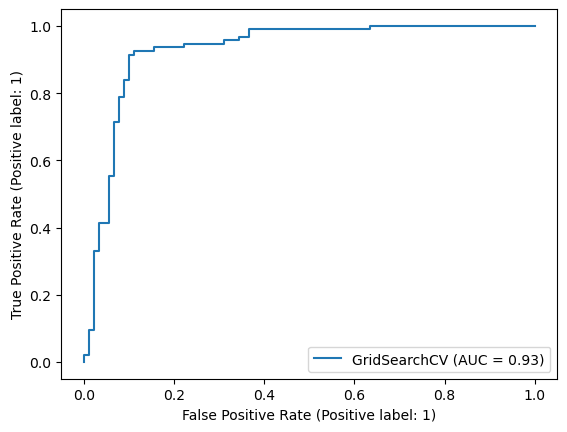

In [29]:
# show true prositive rate based on the number of false prositive rate
RocCurveDisplay.from_estimator(clf_rf, X_test_stdsc_ohe, y_test) 

In [32]:
# select hyperparameters to test for a xgboost model
param_xgb = {
        'min_child_weight': [2, 5],
        'gamma': [1, 2, 5],
        'subsample': [0.5, 0.9],
        'colsample_bytree': [0.5, 0.9],
        'max_depth': [3, 5],
        'n_estimators' : [500],
        'objective' : ['binary:logistic'],
        }

# define xgboost model
xgb = XGBClassifier()

# search for optimal hyperparameters with grid searching
clf_xgb = GridSearchCV(xgb, param_xgb, cv = 5)

# train the model with best parameters
clf_xgb.fit(X_train_stdsc_ohe, y_train)

# show best parameters
print("Best hyperparameters : "+ str(clf_xgb.best_estimator_))

Best hyperparameters : XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


In [33]:
# predict the classes with the trained model on the test dataset
y_pred = clf_xgb.predict(X_test_stdsc_ohe)

# show results and classification performance
show_confusion_matrix(clf_xgb, y_test, y_pred, normalize_matrix = 'no')

Classification report : 
              precision    recall  f1-score   support

           0       0.90      0.83      0.87        90
           1       0.85      0.91      0.88        94

    accuracy                           0.88       184
   macro avg       0.88      0.87      0.87       184
weighted avg       0.88      0.88      0.87       184



In [ ]:
xgb_cv_results = pd.DataFrame(clf_xgb.cv_results_).sort_values("mean_test_score", ascending=False)
xgb_cv_results.head()

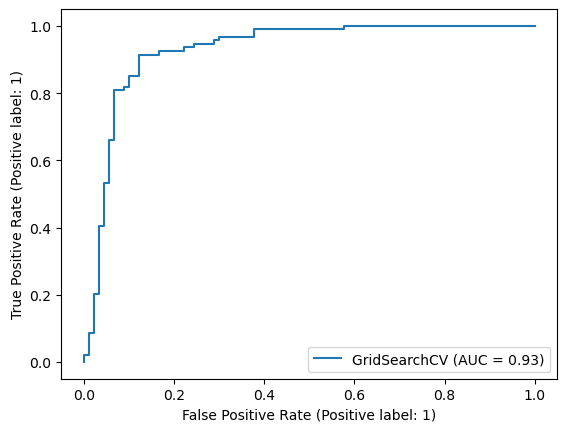

In [34]:
# show true prositive rate based on the number of false prositive rate
RocCurveDisplay.from_estimator(clf_xgb, X_test_stdsc_ohe, y_test) 